In [228]:
import time
from math import log, sqrt
import cPickle as cp
import numpy as np
from PIL import Image, ImageDraw
from ipywidgets import FloatProgress
from IPython.display import display

# Load images and compute integral images

In [200]:
n_images = 4000
im_d = 64
im_d_invsq = 1./(im_d**2)
fn_faces = ["faces/face{}.jpg".format(i) for i in xrange(n_images/2)]
fn_bkgnd = ["background/{}.jpg".format(i) for i in xrange(n_images/2)]
fn_imgs = fn_faces + fn_bkgnd
labels = np.zeros(n_images, dtype='bool')
labels[:n_images/2] = 1

# Compute the Integral Image and variance normalize
iimages = np.zeros((n_images, im_d, im_d), dtype='float64')
for i in xrange(n_images):
    im_arr = np.asarray(Image.open(fn_imgs[i]))
    iimages[i] = im_arr.cumsum(axis=1).cumsum(axis=0)
#     std = im_arr.astype('float64').var()
#     if std > 0:
#         iimages[i] /= std

# Generate features

In [224]:
# Features are of the two-rectange type
# Generate the feature table whose rows store the (x,y) corner coords of the rectangles.
stride = 4

# The primitives define feature shapes and are anchored to (0, 0). The are then translated
# to create multiple features that cover the image. The adjoining edges overlap so that each
# half remain attached at different scales.
primitives = [
    # Feature 1: 8x8 square feature, split evenly horizontally
    np.array([0, 0, 7, 4, 0, 4, 7, 7]),
    # Feature 1: 8x8 square feature, split evenly vertically
    np.array([0, 0, 4, 7, 4, 0, 7, 7]),
    # Feature 3: 16x8 horizontal feature, split evenly horizontally
    np.array([0, 0, 15, 4, 0, 4, 15, 7]),
    # Feature 4: 8x16 vertical feature, split evenly vertically
    np.array([0, 0, 4, 15, 4, 0, 7, 15]),
    # Feature 5: 16x16 square feature, split evenly horizontally
    np.array([0, 0, 15, 8, 0, 8, 15, 15]),
    # Feature 6: 16x16 square feature, split evenly vertically
    np.array([0, 0, 8, 15, 8, 0, 15, 15]),
    # Feature 7: 48x16 horizontal feature, split evenly horizontally
#     np.array([0, 0, 47, 8, 0, 8, 47, 15]),
]

featuretbl = [] 
for feat in primitives:
    width = feat[2] + 1
    height = feat[3] + 1
    
    if feat[4] != 0:
        width += feat[6] - feat[4] + 1
    
    if feat[5] != 0:
        height += feat[7] - feat[5] + 1
    
    # Find number of translations possible with given stride without
    # exceeding image bounds
    n_hor = (im_d - width)/stride + 1
    n_ver = (im_d - height)/stride + 1
    
    new_feat = np.copy(feat)
    for y_incr in xrange(n_ver):
        if y_incr > 0: new_feat[1::2] += stride
        new_feat[::2] = feat[::2]
        for x_incr in xrange(n_hor):
            if x_incr > 0: new_feat[::2] += stride
#             print new_feat
            featuretbl.append(np.copy(new_feat))
featuretbl = np.array(featuretbl)
n_feat = len(featuretbl)

In [202]:
def computeFeatureArr(ii, feat):
    # The sum w/in an area: top left + bottom right - (top right + bottom left)
    # Only the bottom right is within the area of the feature, the others are one outside
    n_images = len(ii)
    ii_areas = np.zeros((n_images, 2))
    for part in xrange(2):
        rect = feat[part*4:part*4+4]
        
        if rect[0]-1 < 0 or rect[1]-1 < 0: # x1 or y1 < 0
            ii_p1 = np.zeros(n_images)
        else:
            ii_p1 = ii[:, rect[1]-1, rect[0]-1]

        if rect[0]-1 < 0:
            ii_p3 = np.zeros(n_images)
        else:
            ii_p3 = ii[:, rect[3], rect[0]-1]

        if rect[1]-1 < 0:
            ii_p2 = np.zeros(n_images)
        else:
            ii_p2 = ii[:, rect[1]-1, rect[2]]

        ii_p4 = ii[:, rect[3], rect[2]]

        ii_areas[:, part] = ii_p4 + ii_p1 - (ii_p2 + ii_p3)
    
    return ii_areas[:, 0] - ii_areas[:, 1]

# Training

In [203]:
def strong_classifier(ii, param_dict):
    if len(ii.shape) != 3:
        raise ValueError("Must supply integral images with array shape (n, d, d).")
    n_weak = len(param_dict["feat"]) 
    h_sum = np.zeros(len(ii))
    alpha_sum = np.zeros(len(ii))
    
    for t in xrange(n_weak):
        f_t = computeFeatureArr(ii, param_dict["feat"][t])
        pre_sgn = param_dict["pol"][t]*(f_t - param_dict["thresh"][t])
        h_t = (pre_sgn > 0).astype('float32')
        h_sum += param_dict["alpha"][t]*h_t
        alpha_sum += param_dict["alpha"][t]
    h_sum -= param_dict["fn_thresh"]
    diff = h_sum - 0.5*alpha_sum
    class_lbls = diff >= 0 
    
    return class_lbls, diff

In [230]:
# %%time
# Train classifier casscade
boost_rnds = [2, 10, 25, 25]
n_stage = len(boost_rnds)
h_cascade = []

orig_idx = [np.arange(n_images)]
n_images_k = n_images
labels_k = np.copy(labels)
iimages_k = iimages[:]

for stage in xrange(n_stage):
    t_strt = time.time()
    print "-----[Cascade Stage {}]-----".format(stage)
    # initialize weights and weak learner param containers
    n_pos = len(labels_k[labels_k])
    n_neg = len(labels_k[np.logical_not(labels_k)])
    w = np.concatenate([np.ones(n_pos)/(2*n_pos), np.ones(n_neg)/(2*n_neg)])

    pol = np.zeros(n_feat)
    thresh = np.zeros(n_feat)
    err = np.zeros(n_feat)
    h = {
        "feat" : [],
        "pol" : [],
        "thresh": [],
        "alpha": [],
        "train_error": [],
        "fn_thresh": 0.
    }
    
    # Want FP rate < 0.3
    for t in xrange(boost_rnds[stage]):
        # normalize weights
        w /= w.sum()

        for j in xrange(n_feat):
            # Value of feature on examples
            f = computeFeatureArr(iimages_k, featuretbl[j])
#             f = np.ones(n_images_k, dtype='int32')
#             f[n_images_k/2:] = 0
#             f[[n_images_k/2, n_images_k/2+2, n_images_k/2+4]] = 1
            sigma = np.argsort(f) # sorted idx

            eps_j = np.zeros(n_images_k)
            pol_j = np.zeros(n_images_k)
            # total weights of partitioning and partitioning error for each image
            for i in xrange(n_images_k):
                s_plus = np.sum(w[sigma[:i]][labels_k[sigma[:i]]])
                s_minus = np.sum(w[sigma[:i]][labels_k[sigma[:i]]==False])
                t_plus = np.sum(w[labels_k])
                t_minus = np.sum(w[labels_k==False])

                # Note: for assignment, must index current element within sorted idx, i.e [sigma[i]]
                # not [sigma][i]
                rel_pos_left = s_plus + (t_minus - s_minus)
                rel_neg_left = s_minus + (t_plus - s_plus)
                if rel_pos_left < rel_neg_left:
                    # more neg on left than positive
                    eps_j[sigma[i]] = rel_pos_left
                    pol_j[sigma[i]] = 1
                else:
                    eps_j[sigma[i]] = rel_neg_left
                    pol_j[sigma[i]] = -1

            eps_min_idx = np.argmin(eps_j[sigma])
            pol[j] = pol_j[sigma[eps_min_idx]]
            thresh[j] = 0.5*(f[sigma[eps_min_idx]] + f[sigma[eps_min_idx-1]]) # avg with j-1 or j+1?

            # Error for the weak classifier is the sum of weights of incorrectly predicted examples 
            err[j] = np.sum(w[((pol[j]*f - thresh[j]) >= 0) != labels_k])
            
        # Find the best weak learner
        best_idx = np.argmin(err)
        beta = err[best_idx] / (1 - err[best_idx])
        if beta == 0.:
            raise ValueError("Weak learner {} with zero error.".format(best_idx))
        alpha = log(1/beta)

        h["feat"].append(featuretbl[best_idx])
        h["pol"].append(pol[best_idx])
        h["thresh"].append(thresh[best_idx])
        h["alpha"].append(alpha)
        h["train_error"].append(err[best_idx])

        f_t = computeFeatureArr(iimages_k, h["feat"][-1])
        h_t =  h["pol"][-1]*(f_t - h["thresh"][-1])

        # Update weights by verifying classification 
        e_t = labels_k != (h_t >= 0) # CHECKME: under current weak classifier or the strong one?
        w = w*beta**(1 - e_t)

        # Set or adjust global threshold to prevent false negatives
        class_lbls, diff = strong_classifier(iimages_k, h)
        n_fnegs = np.sum(np.logical_and(labels_k, labels_k != class_lbls))
        n_tpos = np.sum(np.logical_and(labels_k, labels_k == class_lbls))
        fneg_rate = n_fnegs/float(n_fnegs + n_tpos)
        
        fn_thresh_t = 0.
        if stage < n_stage - 1 and t < boost_rnds[stage] - 1: # Don't adjust for the final stage.
            fn_thresh_t = diff[labels_k].min() # minimum of FN or TP

            if t == 0:
                h["fn_thresh"] = fn_thresh_t
            else:
                h["fn_thresh"] += fn_thresh_t

        # Find the false positives
        n_fpos = np.sum(np.logical_and(~labels_k, labels_k != class_lbls))
        n_tneg = np.sum(np.logical_and(~labels_k, labels_k == class_lbls))
        fpos_rate = n_fpos/float(n_fpos + n_tneg)

        print "Boost {} - feature: {}, train err: {:.2f}, FN: {:.2f}, FP: {:.2f}".format(t, best_idx, err[best_idx],
                                                                                         fneg_rate, fpos_rate)
        print "Theta:", h["fn_thresh"]
    
    h_cascade.append(h)
    
    # Fliter negative examples to FP for next stage
    if stage < n_stage - 1:
        class_lbls = (diff - fn_thresh_t) >= 0
        fpos = np.argwhere(np.logical_and(~labels_k, labels_k != class_lbls)).flatten()
        sele_k = np.concatenate([np.argwhere(labels_k).flatten(), fpos])
        print "FP next stage:", len(fpos)
        n_images_k = len(sele_k)
        labels_k = labels_k[sele_k]
        iimages_k = iimages_k[sele_k]
        orig_idx.append(orig_idx[0][sele_k])
    
    print "Stage completed in {:.2f} min".format((time.time()-t_strt)/60.)

-----[Cascade Stage 0]-----
Boost 0 - feature: 788, train err: 0.17, FN: 0.18, FP: 0.16
Theta: -0.793700046909
Boost 1 - feature: 833, train err: 0.17, FN: 0.01, FP: 0.26
Theta: -0.793700046909
FP next stage: 528
Stage completed in 10.71 min
-----[Cascade Stage 1]-----
Boost 0 - feature: 956, train err: 0.18, FN: 0.14, FP: 0.19
Theta: -0.757891501179
Boost 1 - feature: 824, train err: 0.26, FN: 0.03, FP: 0.31
Theta: -1.29205576797
Boost 2 - feature: 793, train err: 0.26, FN: 0.01, FP: 0.40
Theta: -1.81198570892
Boost 3 - feature: 877, train err: 0.29, FN: 0.00, FP: 0.78
Theta: -2.25206144489
Boost 4 - feature: 258, train err: 0.29, FN: 0.00, FP: 0.81
Theta: -2.70187828027
Boost 5 - feature: 886, train err: 0.29, FN: 0.00, FP: 0.91
Theta: -2.27997660621
Boost 6 - feature: 848, train err: 0.28, FN: 0.00, FP: 0.77
Theta: -2.74219446482
Boost 7 - feature: 582, train err: 0.32, FN: 0.00, FP: 0.79
Theta: -3.12082978291
Boost 8 - feature: 789, train err: 0.33, FN: 0.00, FP: 0.89
Theta: -2.775

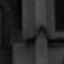

In [212]:
# Check selected images
stage = 3
img = Image.open(fn_imgs[orig_idx[stage][-5]])
display(img)

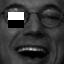

In [247]:
# Examine features picked during boosting
img = Image.open("faces/face803.jpg")
stage = 2
weak = 0 
draw = ImageDraw.Draw(img)
draw.rectangle(list(h_cascade[stage]["feat"][weak][:4]), fill='white')
draw.rectangle(list(h_cascade[stage]["feat"][weak][4:]), fill='black')
display(img)

In [237]:
# with open("trained_params_Theta.pkl", 'w') as f:
#     cp.dump(h_cascade, f)

with open("trained_params_Theta.pkl") as f:
    h_cascade = cp.load(f)

# Detection on test image

In [239]:
class vj_detector:
    """Viola-Jones Face Detector"""
    
    def __init__(self, param_list):
        self.param_list = param_list
        
    def classifier_cascade(self, ii_arr, ii, wndw, scale, x_shift, y_shift):
        n_stage = len(self.param_list)
        scale_sq = scale**2
#         wndw_std = np.std((ii_arr[wndw[1]:wndw[3]+1, wndw[0]:wndw[2]+1]).astype('float64'))
        
        for stage in xrange(n_stage):
            param_dict = self.param_list[stage]

            n_weak = len(param_dict["feat"]) 
            h_sum = np.zeros(len(ii))
            alpha_sum = np.zeros(len(ii))

            for t in xrange(n_weak):
                feat_t = (scale*np.copy(param_dict["feat"][t])).astype('int32')
                feat_t[::2] += x_shift
                feat_t[1::2] += y_shift
                # ToDo: more efficient computeFeature that vectorizes over features.
                f_t = computeFeatureArr(ii, feat_t) #/ wndw_std
                # CheckMe: should h_t threshold change by scale or scale**2?
                h_t = (param_dict["pol"][t]*(f_t - scale_sq*param_dict["thresh"][t]) > 0).astype('float64')
                h_sum += param_dict["alpha"][t]*h_t
                alpha_sum += param_dict["alpha"][t]
            if stage < 1: h_sum -= param_dict["fn_thresh"]
            diff = h_sum -0.5*alpha_sum
            class_lbls = diff >= 0 
            if not class_lbls[0]:
                break

        return class_lbls
    
    def detect(self, im_arr):
        # np array of single image
        im_dy = im_arr.shape[0]
        im_dx = im_arr.shape[1]
        iimages = im_arr.cumsum(axis=1).cumsum(axis=0).astype('float64')
        iimages.shape = (1,) + iimages.shape
        
        faces = []
        face_mask = np.zeros((im_dy, im_dx), dtype='bool') # prevent too much overlap in detections      
        
        for scale in [1.]:
            stride = int(scale*4)
            wndw_size = int(scale*64)
            wndw = np.array([0, 0, wndw_size-1, wndw_size-1], dtype='int32')
            mask_thresh = 0.25*64**2

            # Find number of window translations possible with given stride without
            # exceeding image bounds
            n_hor = (im_dx - wndw_size)/stride + 1
            n_ver = (im_dy - wndw_size)/stride + 1
            
            pbar = FloatProgress(min=0, max=n_hor*n_ver)
            display(pbar)
            y_shift = 0
            for y_incr in xrange(n_ver):
                if y_incr > 0:
                    wndw[1::2] += stride
                    y_shift += stride
                wndw[::2] = [0, wndw_size-1]
                x_shift = 0

                skip = 0
                for x_incr in xrange(n_hor):
                    if x_incr > 0:
                        wndw[::2] += stride
                        x_shift += stride

                    if skip == 0:
                        # check if prev face detected overlaps with current window 
                        mask_chk = np.sum(face_mask[wndw[1]:wndw[3]+1, wndw[0]:wndw[2]+1]) 
                        if mask_chk < mask_thresh:
                            lbl = self.classifier_cascade(im_arr, iimages, wndw, scale, x_shift, y_shift)
                            if lbl[0] == 1:
                                faces.append(np.copy(wndw))
                                skip += wndw_size - 1 # skip a window length if face detected
                                face_mask[wndw[1]:wndw[3]+1, wndw[0]:wndw[2]+1] = 1
                    else:
                        skip -= 1
                    
                    pbar.value += 1
        
        return faces

In [240]:
%%time
img = Image.open("class.jpg")
im_arr = np.asarray(img)

vj_detect = vj_detector(h_cascade)
faces = vj_detect.detect(im_arr)

CPU times: user 2min 35s, sys: 33.9 s, total: 3min 9s
Wall time: 2min 32s


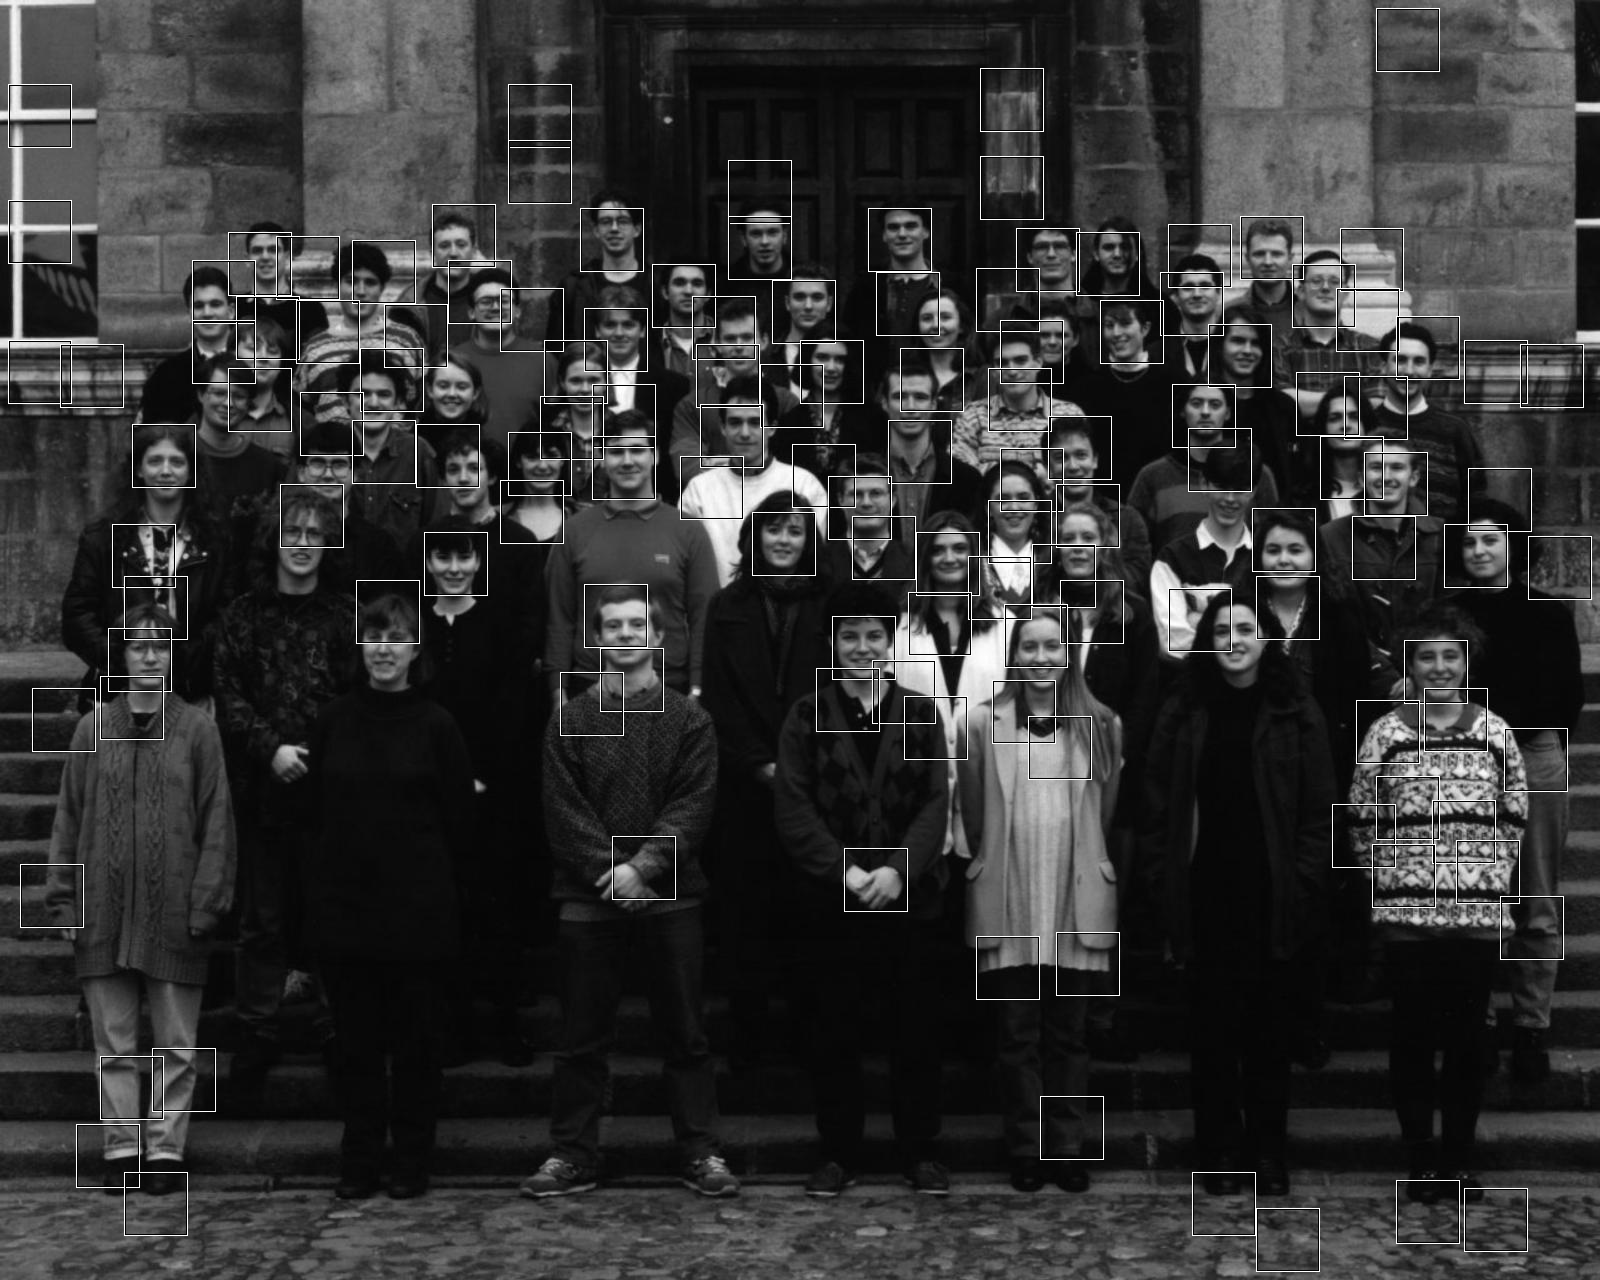

In [241]:
draw = ImageDraw.Draw(img)
for face in faces:
    rect1 = list(face)
    rect2 = np.copy(face)
    rect2[:2] += 1
    rect2[-2:] -= 1
    rect2 = list(rect2)
    
    draw.rectangle(rect1, outline='white')
    draw.rectangle(rect2, outline='black')
display(img)